In [1]:
# get the code for kaggle
!git clone https://github.com/moaaztaha/Image-Captioning
py_files_path = '/kaggle/working/Image-Captioning/'
import sys
sys.path.append(py_files_path)

Cloning into 'Image-Captioning'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 169 (delta 93), reused 109 (delta 35), pack-reused 0
Receiving objects: 100% (169/169), 10.10 MiB | 23.34 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms


import pandas as pd
import numpy as np
import spacy

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, math, random

from datasets import build_vocab, get_loaders
from models import Img2Seq, EncoderCNN, DecoderGRU
from utils import train, evaluate, epoch_time, print_examples, predict_test, print_scores
from utils import get_test_data

%matplotlib inline

In [4]:
# making our results reproducable
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# speedup training
#torch.backends.cudnn.benchmark = True

In [5]:
spacy_en = spacy.load('en')
MODEL_PATH = 'models/splits.pth'
IMAGES_PATH = '../input/flickr8k/Images/'
DF_PATH = '/kaggle/working/Image-Captioning/data.csv'
TEST_DF_PATH = '/kaggle/working/Image-Captioning/test.csv'
TEST_EXAMPLES_PATH = '/kaggle/working/Image-Captioning/test_examples/'

In [6]:
vocab = build_vocab(DF_PATH)

In [7]:
pad_idx = vocab.stoi['<pad>']

In [21]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(vocab)
TRAIN_CNN = False
bs = 256
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(HID_DIM, DROPOUT)
decoder = DecoderGRU(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(encoder, decoder, device).to(device)

In [9]:
# transforms 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = TRAIN_CNN

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 3,207,789 trainable parameters.


In [15]:
train_loader, valid_loader = get_loaders(bs, IMAGES_PATH, DF_PATH, transform, vocab)

Dataset split: train
Unique Image: 6000
Size: 30000
Dataset split: val
Unique Image: 1000
Size: 5000


In [16]:
import multiprocessing
multiprocessing.cpu_count()

2

In [18]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru.pth')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

KeyboardInterrupt: 

In [22]:
model.load_state_dict(torch.load('gru.pth'))

<All keys matched successfully>

Output: a dog is running through the grass .


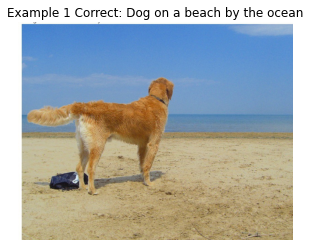

Output: a young boy wearing a blue shirt and shorts is standing on a rock .


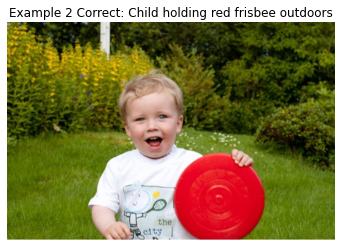

Output: a man in a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and


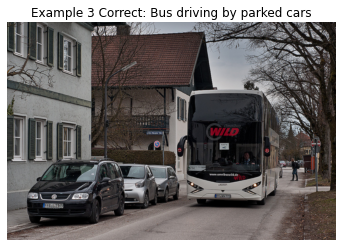

Output: a man in a black wetsuit is surfing on a wave .


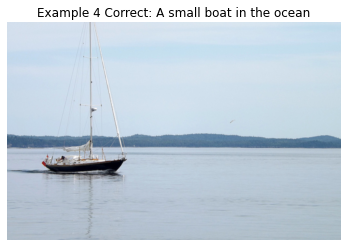

Output: a man is standing on a rock overlooking a lake .


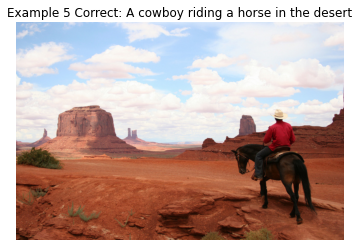

In [23]:
print_examples(model, TEST_DF_PATH, vocab, TEST_EXAMPLES_PATH)

In [24]:
test_dict = get_test_data(DF_PATH)

In [25]:
preds, trgs = predict_test(test_dict, IMAGES_PATH, model, vocab, n_images=1000)

prediction: a black dog is running through the grass .
actaul 1: a group of dogs runs beside a pond through a field .
prediction: a young girl in a pink shirt and blue jeans is picking blossoms on her hands .
actaul 1: a girl wets her head in a white bucket .
prediction: a man in a black shirt and a black shirt and a white shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a woman in a black dress and a
actaul 1: a group of men wearing yellow shawls walk in a line .
prediction: a man is standing on top of a mountain gazing .
actaul 1: a boy and a girl playing on the beach .
prediction: a young boy wearing a blue shirt and blue jeans is playing with a soccer ball .
actaul 1: children participate in a sport on a green field while in uniforms .
prediction: a black dog is running through the grass .
actaul 1: a boy wearing a teal shirt is riding a skateboard on a sidewalk .
prediction: a young boy is playing with a soccer b

In [26]:
len(preds), (len(trgs), len(trgs[0]))

(1000, (1000, 5))

In [27]:
print_scores(preds, trgs)

1: 30.748429894447327
2: 17.198263108730316
3: 9.550952166318893
4: 5.121536552906036


<a href='./gru.pth'>download</a>